# Исследования данных игр

Для интернет-магазина, который продаёт по всему миру компьютерные игры, необходимо спланировать закуп на следующий год и разработать рекламные кампании.
Проанализируем доступные исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Выявим определяющие успешность игры закономерности.

## Файл с данными и общая информация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
try:
    data = pd.read_csv('C:/Users/Karasiq/Downloads/games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')
data.info()
data
print(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
R

Посмотрели информацию о датасете. Есть пропуски и не во всех столбцах указан правильный тип данных.
Заменим названия столбцов, преобразуем тип данных и обработаем пропуски.

In [3]:
data.columns = [x.lower() for x in data.columns]
data[data['name'].isna()]
data[data['year_of_release'].isna()].head(30)
data = data.dropna(subset=['name','year_of_release'])
data['year_of_release'] = data['year_of_release'].astype('int')

data.loc[data['user_score'] == 'tbd', 'user_score'] = None
data['user_score'] = pd.to_numeric(data['user_score'])


Пропущенные значения в столбцах имя и год релиза мало(смело удаляем). Строки со значенем 'tbd' в столбце юзер заменим на пропуск.
Доля продаж игр с рейтингом, подлежащим уточнению, мала. Вот с остальными пропусками все гораздо сложнее.


Перед тем как заполнить пропуски в оставшихся столбцах, посчитаем сумарные продажи.

In [4]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data['total_sales'].describe()

count    16444.000000
mean         0.536023
std          1.558786
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: total_sales, dtype: float64

Пропущенные значения в столбце 'rating' заполнить самостоятельно не получиться. Оставим пропуски в этом столбце.

In [5]:
data.duplicated().sum()

0

Явных дубликатов в датафрейме нет.

In [6]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
total_sales           0
dtype: int64

Остались пропуски в рейтинге ESRB (рейтинг видеоигр для США, Канады и Мексики). Возможно, наличие пропусков в этом столбце связанно с тем, что у ряда игры нет соотвутсвующей рейтинговой модели (а есть своя - региональная).

In [7]:
data['rating'] = data['rating'].fillna('UNKW')

## Рассмотрим выпуск игр в разные годы.

[Text(0.5, 1.0, 'Гистограмма выпуска игр'),
 Text(0.5, 0, 'Год выпуска'),
 Text(0, 0.5, 'Кол-во игры')]

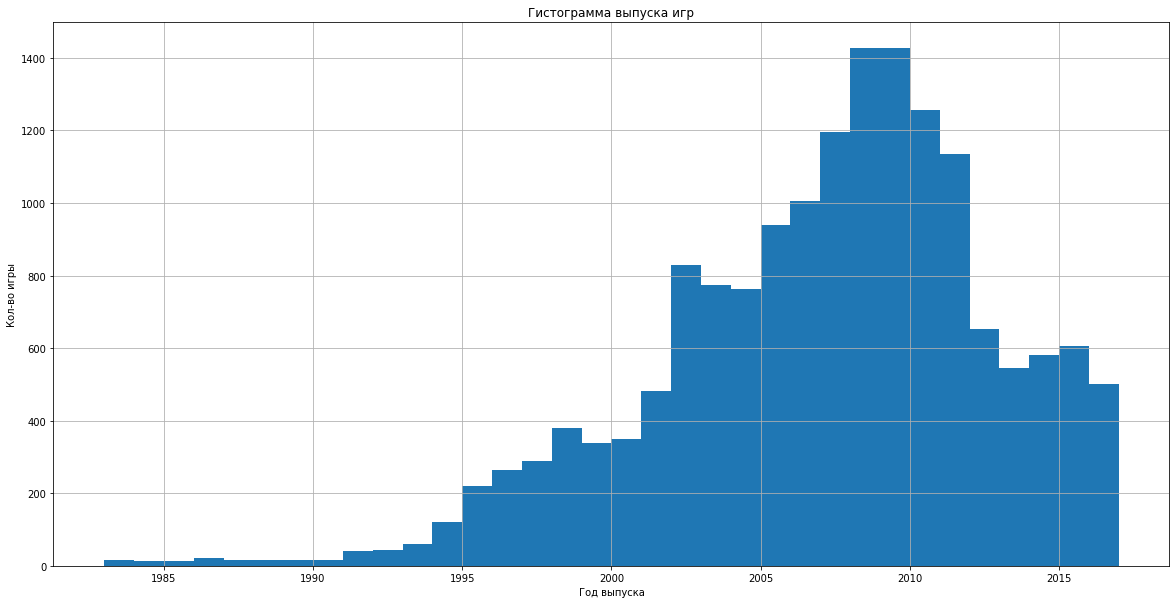

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

data['year_of_release'].hist(bins=34, range=(1983,2017),figsize=(20,10)).set(title='Гистограмма выпуска игр',\
                                                                             xlabel='Год выпуска',ylabel = 'Кол-во игры')


До 1994 года выпускалось мало игр. Данными до этого года можно пренебречь. Также с 2008 года наблюдался спад выпуска игр.


<AxesSubplot:xlabel='platform', ylabel='total_sales'>

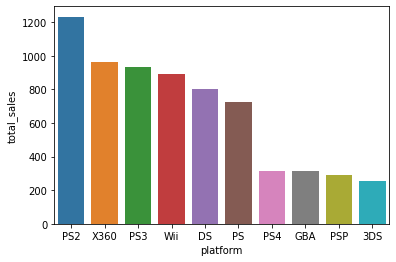

In [9]:
plat_sales = data.pivot_table(index='platform', values='total_sales',aggfunc='sum').sort_values('total_sales',ascending=False).head(10).reset_index()
plat_sales.reset_index().sort_values(by='total_sales',ascending=False)
sns.barplot(data=plat_sales, x="platform", y="total_sales")

Получили список самых популярных платформ по продажам и построили график.

RangeIndex(start=0, stop=10, step=1)

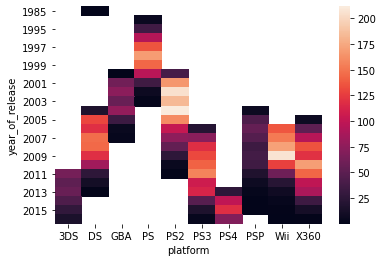

In [10]:
plat_sales_byear = data.query('platform in @plat_sales["platform"]').pivot_table(index='platform',\
                                                                          columns='year_of_release', values ='total_sales',aggfunc='sum')
import seaborn as sns
sns.heatmap(plat_sales_byear.T)
plat_sales.index

In [11]:
data.query('platform == "DS"').sort_values(by='year_of_release')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.00,0.00,0.02,0.00,NaN,NaN,UNKW,0.02
13463,Cocoto Kart Racer,DS,2004,Racing,0.04,0.00,0.00,0.00,NaN,NaN,E,0.04
11517,Kenshuui Tendo Dokuta,DS,2004,Simulation,0.00,0.00,0.08,0.00,NaN,NaN,UNKW,0.08
4421,The Urbz: Sims in the City (all regions sales),DS,2004,Simulation,0.40,0.01,0.02,0.00,NaN,NaN,UNKW,0.43
7902,Daigasso! Band Brothers,DS,2004,Misc,0.00,0.00,0.19,0.00,NaN,NaN,UNKW,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...
7460,Disney's Planes,DS,2013,Simulation,0.11,0.08,0.00,0.02,NaN,NaN,E,0.21
14716,LEGO Legends of Chima: Laval's Journey,DS,2013,Adventure,0.00,0.03,0.00,0.00,NaN,NaN,E10+,0.03
7993,The Smurfs 2,DS,2013,Platform,0.00,0.17,0.00,0.01,NaN,NaN,E,0.18
3862,Frozen: Olaf's Quest,DS,2013,Platform,0.21,0.26,0.00,0.04,NaN,NaN,UNKW,0.51


In [12]:
data.loc[data['name'] == 'Strongest Tokyo University Shogi DS', 'year_of_release'] = 2010

Распределение по годам построили.

Рассмотрим срок появление и исчезнавения платформ.

count    31.000000
mean      7.645161
std       5.063256
min       1.000000
25%       4.000000
50%       7.000000
75%      10.500000
max      26.000000
Name: platform, dtype: float64

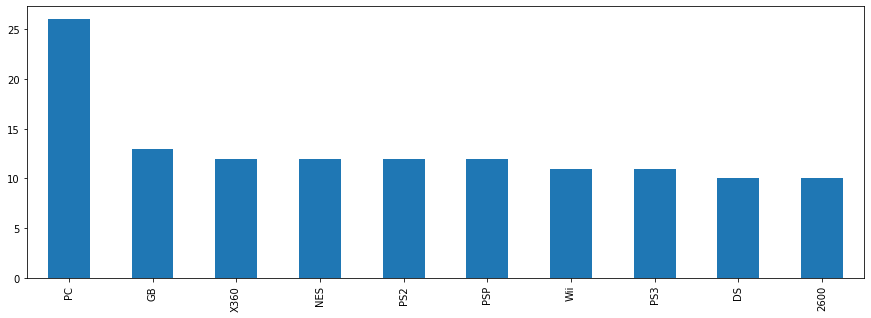

In [13]:
platform_exist = data.groupby(['platform','year_of_release']).agg({'total_sales':'sum'}).reset_index()
platform_exist['platform'].value_counts().head(10).plot(kind='bar',figsize=(15,5))
platform_exist['platform'].value_counts().describe()


Среднее значение существование новых платформ - 7 лет. Наиболее популярные платформы остаются на рынке 12+ лет. 


Для разработки рекламной кампании необходимо взять данные за актуальны период. Индустрия игр активно развивается, количество выпуска игр и популярность платформ постоянное изменияется. Чтобы не захватить уже отжившие тредны возьмем данные с 2012 года.

<AxesSubplot:title={'center':'Продажми с 2012 года'}, xlabel='Год', ylabel='Продажи'>

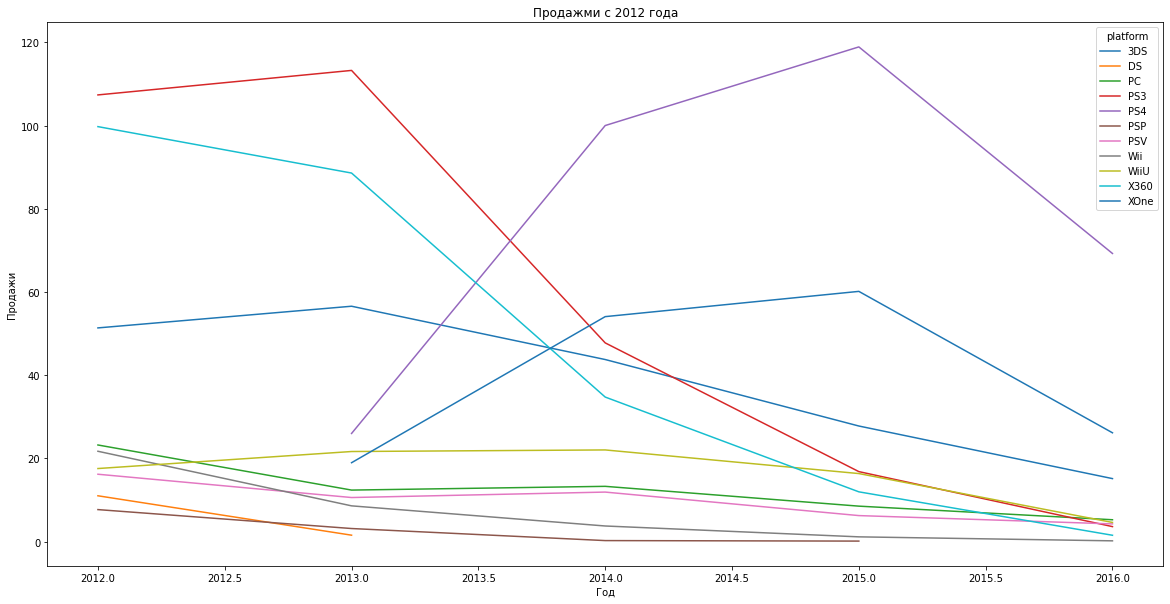

In [14]:
data_2010 = data.query('year_of_release >= 2012')
data_2010.pivot_table(index ='year_of_release',columns='platform',values='total_sales',aggfunc='sum').plot(figsize=(20,10),\
                                                                                                          xlabel=('Год'),
                                                                                                          ylabel=('Продажи'),
                                                                                                          title=('Продажми с 2012 года'))

Продажи на всех платформах только падают. Есть, конечно, платформы со стабильно низкими продажами (например пк). 
Выберем из этих платформ наиболее прибыльные.

In [15]:
data_2010_top = data_2010.pivot_table(index='platform',values='total_sales',aggfunc='sum')
data_2010_top.sort_values('total_sales',ascending=False).reset_index()


,platform,total_sales
0,PS4,314.14
1,PS3,288.79
2,X360,236.54
3,3DS,194.61
4,XOne,159.32
5,WiiU,82.19
6,PC,62.65
7,PSV,49.18
8,Wii,35.37
9,DS,12.55


Наиболее прибыльные платформы: ps4, ps3, x360,3ds.
Но продажи не растут нигде. 
Построим график - ящик с усами.

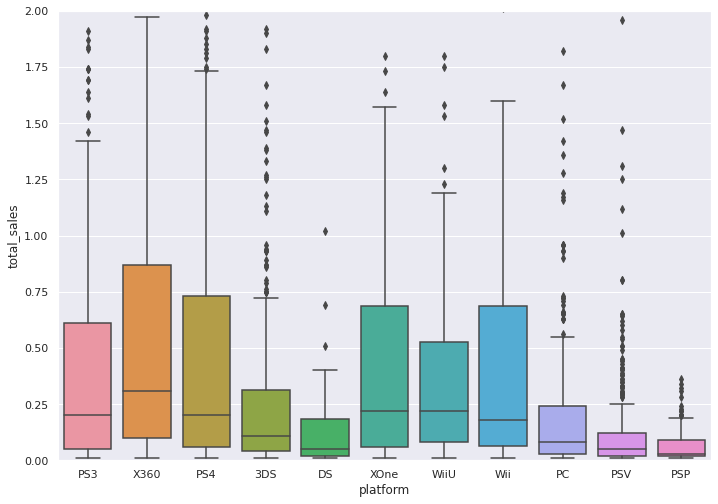

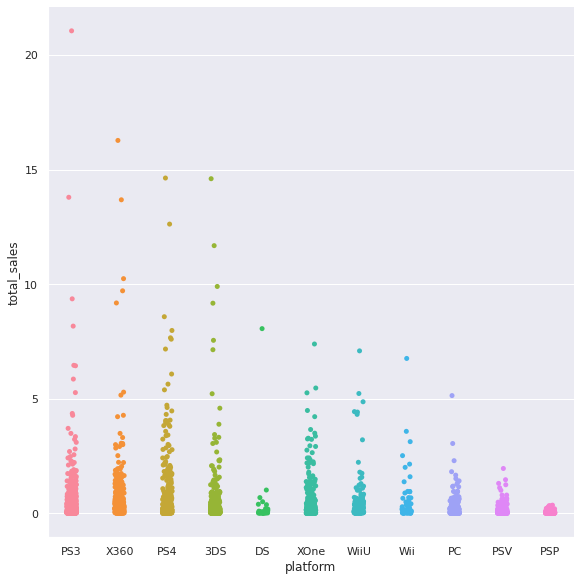

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.ylim(0, 2)
sns.boxplot(x=data_2010['platform'],y=data_2010['total_sales'])
sns.catplot(x=data_2010['platform'],y=data_2010['total_sales'],data=data_2010, height=8)

Данные очень разбросаны, много выбросов. Топ 5 платформ отрываются от остальных с большим отрывом.
Далее, рассмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

<function matplotlib.pyplot.show(close=None, block=None)>

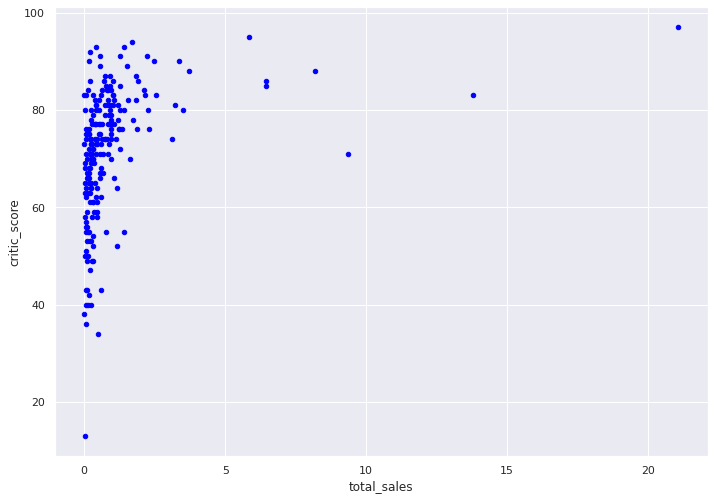

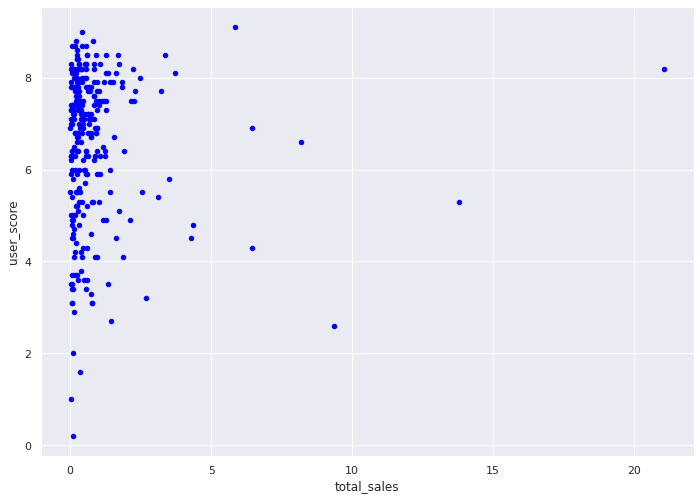

In [17]:
data_ps3 = data_2010.query('platform == "PS3"')
#pd.plotting.scatter_matrix(data_ps3[['total_sales','critic_score','user_score']])
data_ps3.plot(kind='scatter',x='total_sales',y='critic_score',color='blue')
data_ps3.plot(kind='scatter',x='total_sales',y='user_score',color='blue')
plt.show

По диаграмме можно сделать вывод, что оценка критиков связана с продажами. Связи оценки пользователей и количеством продаж на ps3 не наблюдается. 

In [18]:
print(data_ps3[['total_sales','critic_score','user_score']].corr())

              total_sales  critic_score  user_score
total_sales      1.000000      0.331497   -0.005144
critic_score     0.331497      1.000000    0.539456
user_score      -0.005144      0.539456    1.000000


Имееться слабая положительна связь между продажами и оценками критиков. А также между оценками критиков и пользователей(просто интересный факт).

Соотнесем с выводами по другим платформам:PS4, PS3,	X360, 3DS	

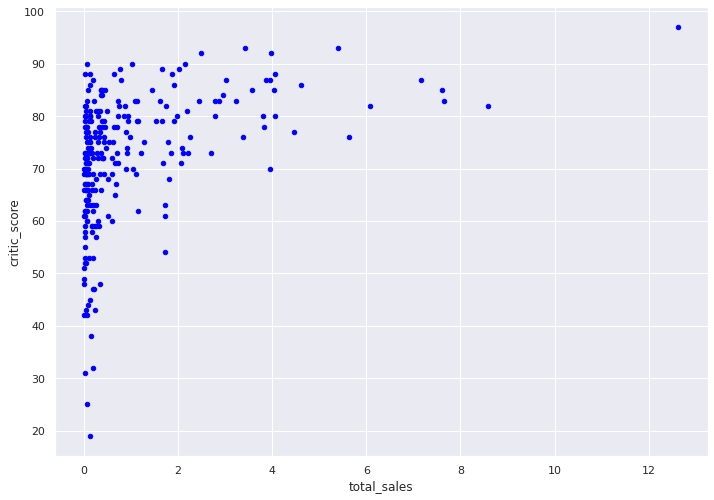

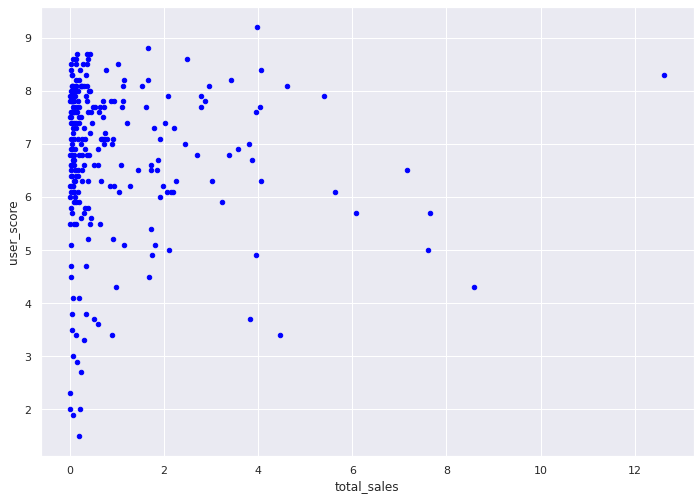

              total_sales  critic_score  user_score
total_sales      1.000000      0.406568   -0.031957
critic_score     0.406568      1.000000    0.557654
user_score      -0.031957      0.557654    1.000000


In [19]:
data_ps4 = data_2010.query('platform == "PS4"')
data_ps4.plot(kind='scatter',x='total_sales',y='critic_score',color='blue')
data_ps4.plot(kind='scatter',x='total_sales',y='user_score',color='blue')
plt.show()
print(data_ps4[['total_sales','critic_score','user_score']].corr())

На ps4 практически аналогичная ситуация, как у ps3. Имеется незначительная положителньая связь между оценками критиков и продажами.

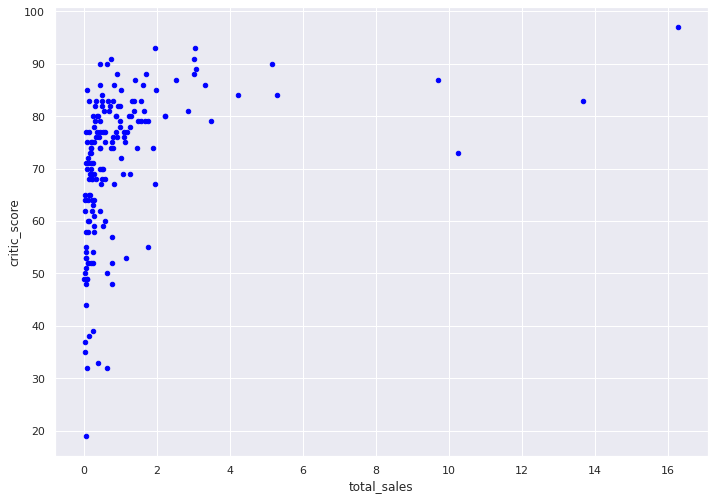

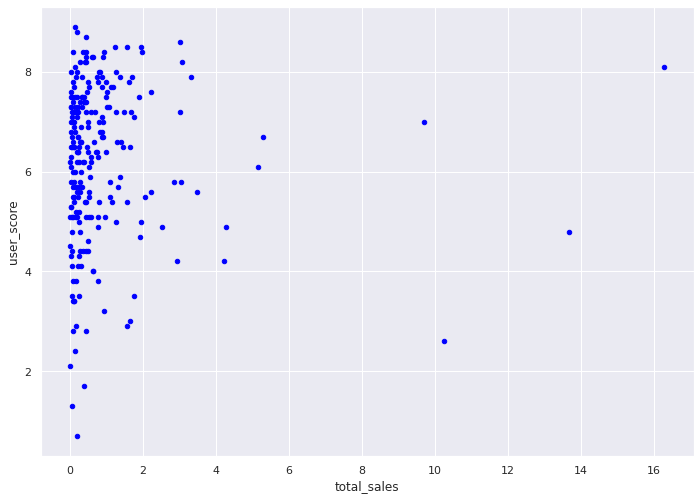

              total_sales  critic_score  user_score
total_sales      1.000000      0.360573    0.006164
critic_score     0.360573      1.000000    0.557352
user_score       0.006164      0.557352    1.000000


In [20]:
data_х360 = data_2010.query('platform == "X360"')
data_х360.plot(kind='scatter',x='total_sales',y='critic_score',color='blue')
data_х360.plot(kind='scatter',x='total_sales',y='user_score',color='blue')
plt.show()
print(data_х360[['total_sales','critic_score','user_score']].corr())

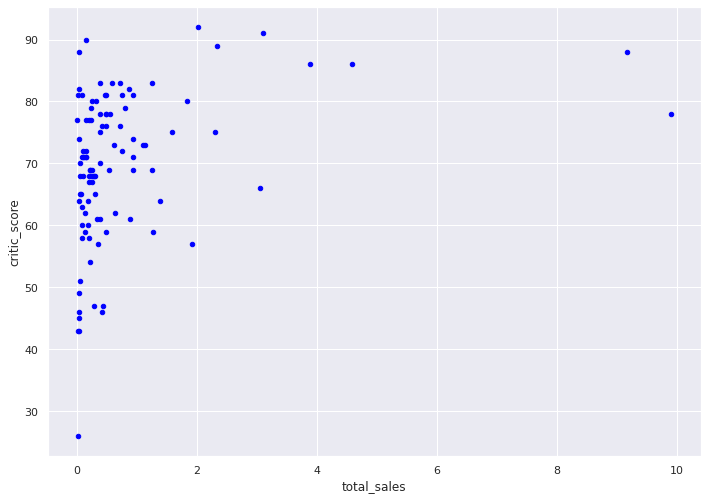

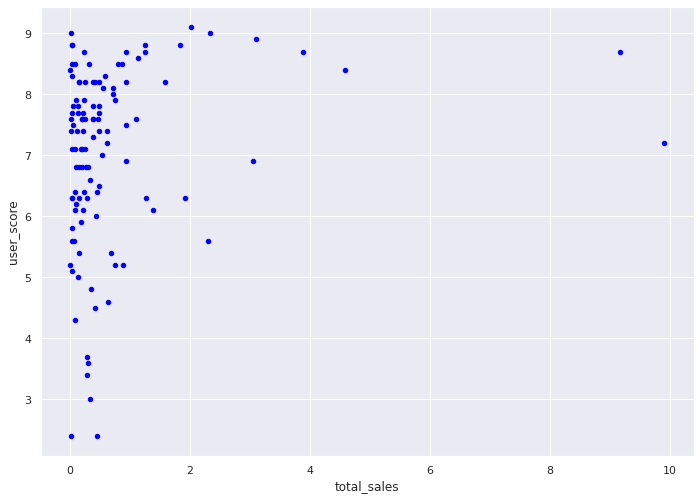

              total_sales  critic_score  user_score
total_sales      1.000000      0.320803    0.197583
critic_score     0.320803      1.000000    0.722762
user_score       0.197583      0.722762    1.000000


In [21]:
data_3ds = data_2010.query('platform == "3DS"')
data_3ds.plot(kind='scatter',x='total_sales',y='critic_score',color='blue')
data_3ds.plot(kind='scatter',x='total_sales',y='user_score',color='blue')
plt.show()
print(data_3ds[['total_sales','critic_score','user_score']].corr())

На всех наиболее популярных (ps3,ps4,x360,3ds) платформах наблюдается слабая положительная связь между оценками критиков и продажами. 

Посмотрим на распределение игр по жанрам.

In [22]:
data_2010_genre = data_2010.pivot_table(index='genre',values='total_sales',aggfunc='median').reset_index()
#sns.boxplot(data = data_2010_genre.sort_values(by='total_sales',ascending=False), y='total_sales',x='genre')
data_2010_genre.sort_values(by='total_sales',ascending=False)

,genre,total_sales
8,Shooter,0.440
10,Sports,0.240
4,Platform,0.210
7,Role-Playing,0.140
6,Racing,0.140
2,Fighting,0.130
0,Action,0.120
3,Misc,0.120
9,Simulation,0.120
11,Strategy,0.080


Самые популярные жанры: шутеры, платформеры, спорт.

<AxesSubplot:xlabel='genre', ylabel='total_sales'>

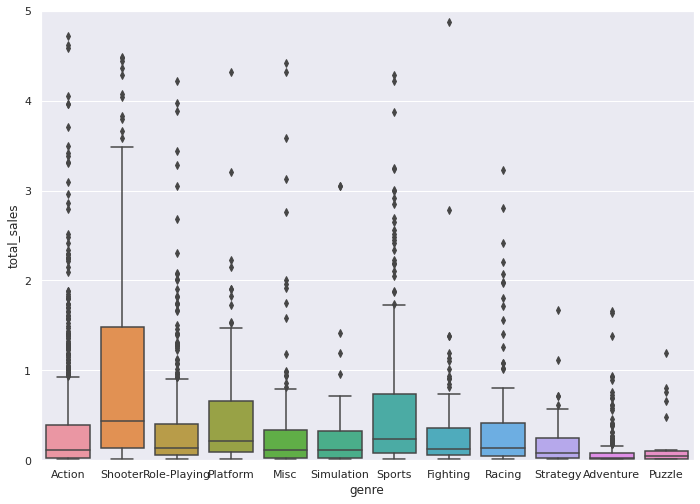

In [23]:
#data_2010.plot(kind='scatter',x='genre',y='total_sales')
plt.ylim(0, 5)
sns.boxplot(x=data_2010['genre'],y=data_2010['total_sales'])

Общий вывод. 
Проанализировав данные с 2012 года были выделенные самые популярные платформы: ps4, ps3, x360, 3ds, xOne. 
Положительной связи между продажами и оценками игроков нет; между оценкой критиков и продажами - слабая.

Самыми популярными жанрами являются: шутер, спорт, платформер и рол-плей. Шутер и платформер наиболее стабильные жанры, когда у жанра спорт и рол-плей много продаж за рамками "усов". Скорее всего, эти жанры популярны на определенных платформах.


##  Портреты пользователей.

In [24]:
#самые популярные платформы
data_reg = data_2010.pivot_table(index='platform',values=['eu_sales','na_sales','jp_sales'],aggfunc='sum').reset_index()
data_reg

#самые популярны платформы для европы
data_reg.sort_values('eu_sales',ascending=False)

#для японии
data_reg.sort_values('jp_sales',ascending=False)

#для северной америки
data_reg.sort_values('na_sales',ascending=False)

,platform,eu_sales,jp_sales,na_sales
9,X360,74.52,1.57,140.05
4,PS4,141.09,15.96,108.74
3,PS3,106.86,35.29,103.38
10,XOne,51.59,0.34,93.12
0,3DS,42.64,87.79,55.31
8,WiiU,25.13,13.01,38.10
2,PC,37.76,0.00,19.12
7,Wii,11.92,3.39,17.45
6,PSV,11.36,21.04,10.98
1,DS,3.53,3.72,4.59


Топ 5 платформ в европе: ps3,x360,ps4,xOne,3Ds.
Топ 5 платформ в Японии: 3ds,ps3,psv,ps4,wiiU
Топ 5 платформ в Северной Америке: x360,ps3,ps4,xOne,3DS.

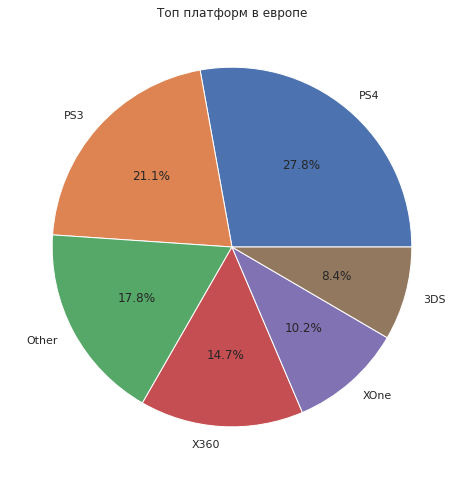

In [25]:
data_reg_eu = data_reg[['platform','eu_sales']].sort_values(by='eu_sales',ascending=False).reset_index(drop=True)
s_other = ['Other',sum(data_reg_eu.loc[5:,'eu_sales'])]
data_reg_eu.loc[len(data_reg_eu)] = s_other
data_reg_eu = data_reg_eu.sort_values(by='eu_sales',ascending=False)
plt.title('Топ платформ в европе')
plt.pie(data=data_reg_eu[:6],x='eu_sales',labels='platform',autopct='%1.1f%%')
plt.show()

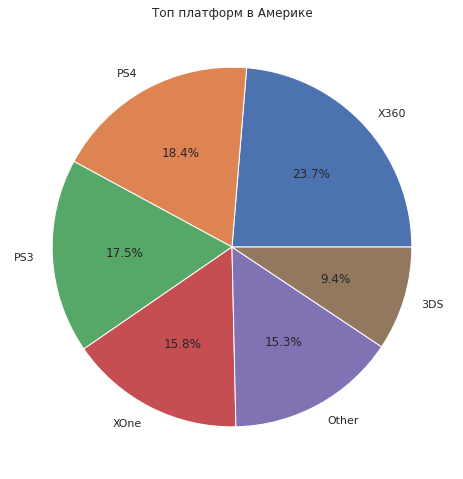

In [26]:
data_reg_na = data_reg[['platform','na_sales']].sort_values(by='na_sales',ascending=False).reset_index(drop=True)
s_other2 = ['Other',sum(data_reg_na.loc[5:,'na_sales'])]
data_reg_na.loc[len(data_reg_na)] = s_other2
data_reg_na = data_reg_na.sort_values(by='na_sales',ascending=False)
plt.title('Топ платформ в Америке')
plt.pie(data=data_reg_na[:6],x='na_sales',labels='platform',autopct='%1.1f%%')
plt.show()

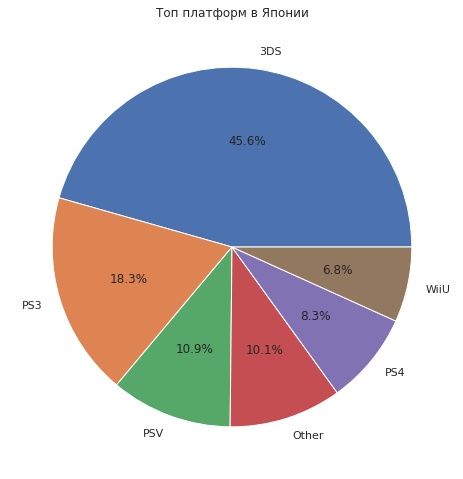

In [27]:
data_reg_jp = data_reg[['platform','jp_sales']].sort_values(by='jp_sales',ascending=False).reset_index(drop=True)
s_other3 = ['Other',sum(data_reg_jp.loc[5:,'jp_sales'])]
data_reg_jp.loc[len(data_reg_jp)] = s_other3
data_reg_jp = data_reg_jp.sort_values(by='jp_sales',ascending=False)
plt.title('Топ платформ в Японии')
plt.pie(data=data_reg_jp[:6],x='jp_sales',labels='platform',autopct='%1.1f%%')
plt.show()

In [28]:
#самые популярные жанры
data_genre_pop = data_2010.pivot_table(index='genre',values=['eu_sales','na_sales','jp_sales'],aggfunc='sum').reset_index()
data_genre_pop

#самые популярны жанры для европы
data_genre_pop.sort_values('eu_sales',ascending=False)

#для японии
data_genre_pop.sort_values('jp_sales',ascending=False)

#для северной америки
data_genre_pop.sort_values('na_sales',ascending=False)

,genre,eu_sales,jp_sales,na_sales
0,Action,159.34,52.80,177.84
8,Shooter,113.47,9.23,144.77
10,Sports,69.09,8.01,81.53
7,Role-Playing,48.53,65.44,64.00
3,Misc,26.32,12.86,38.19
4,Platform,21.41,8.63,25.38
2,Fighting,10.79,9.44,19.79
6,Racing,27.29,2.50,17.22
1,Adventure,9.46,8.24,8.92
9,Simulation,14.55,10.41,7.97


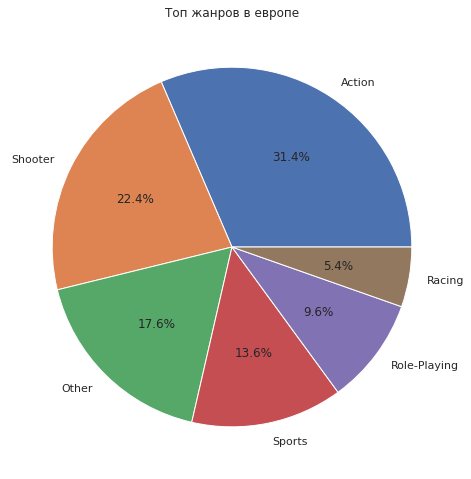

In [29]:
data_genre_pop_eu = data_genre_pop[['genre','eu_sales']].sort_values(by='eu_sales',ascending=False).reset_index(drop=True)
g_other = ['Other',sum(data_genre_pop_eu.loc[5:,'eu_sales'])]
data_genre_pop_eu.loc[len(data_genre_pop_eu)] = g_other
data_genre_pop_eu = data_genre_pop_eu.sort_values(by='eu_sales',ascending=False)
plt.title('Топ жанров в европе')
plt.pie(data=data_genre_pop_eu[:6],x='eu_sales',labels='genre',autopct='%1.1f%%')
plt.show()

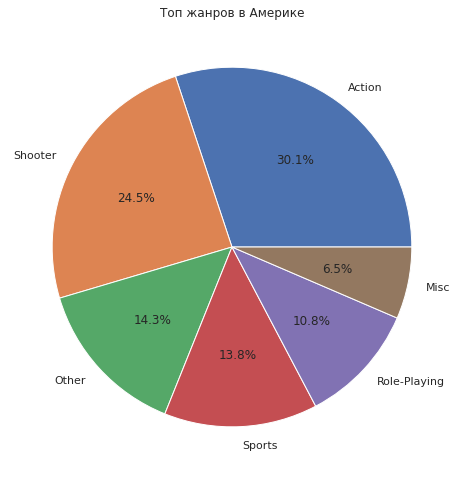

In [30]:
data_genre_pop_na = data_genre_pop[['genre','na_sales']].sort_values(by='na_sales',ascending=False).reset_index(drop=True)
g_other2 = ['Other',sum(data_genre_pop_na.loc[5:,'na_sales'])]
data_genre_pop_na.loc[len(data_genre_pop_na)] = g_other2
data_genre_pop_na = data_genre_pop_na.sort_values(by='na_sales',ascending=False)
plt.title('Топ жанров в Америке')
plt.pie(data=data_genre_pop_na[:6],x='na_sales',labels='genre',autopct='%1.1f%%')
plt.show()

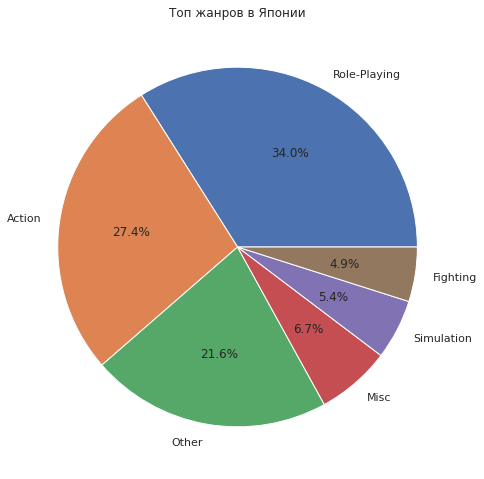

In [31]:
data_genre_pop_jp = data_genre_pop[['genre','jp_sales']].sort_values(by='jp_sales',ascending=False).reset_index(drop=True)
g_other3 = ['Other',sum(data_genre_pop_jp.loc[5:,'jp_sales'])]
data_genre_pop_jp.loc[len(data_genre_pop_jp)] = g_other3
data_genre_pop_jp = data_genre_pop_jp.sort_values(by='jp_sales',ascending=False)
plt.title('Топ жанров в Японии')
plt.pie(data=data_genre_pop_jp[:6],x='jp_sales',labels='genre',autopct='%1.1f%%')
plt.show()

Топ 5 жанров в европе: экшен, шутер, спорт, рол-плей, misc.
Топ 5 жанров в Японии: рол-плей, экшен, misc, платформер, приключения. 
Топ 5 жанров в Северной Америке: экшен, шутер, спорт, рол-плей, misc.

Рынок платформ в европе и америке очень похож, как и популярность жанров. В свою очередь, в японии доминирующей платформой является 3DS, а такие жанры как спорт и шутер(самые популярные в двух остальных регионах) имеют долю на рынке меньше 4%.

In [32]:
#продажи по рейтингу ESRB 
data_esrb = data_2010.pivot_table(index='rating',values=['eu_sales','na_sales','jp_sales'],aggfunc='sum').reset_index()
data_esrb

,rating,eu_sales,jp_sales,na_sales
0,E,113.03,28.33,114.37
1,E10+,55.37,8.19,75.70
2,M,193.96,21.20,231.57
3,T,52.96,26.02,66.02
4,UNKW,91.50,108.84,103.31


В европе и Америке самые популярные игры с рейтингом М и E. 
В японии - игры без рейтинга ESRB.
Доля продаваемых игры без рейтинга ESRB на рынках Америки и европы тоже является значительной.


Выводы: были найдены топ 5 платформ по регионам и топ 5 жанров по регионам.
Предпочтения по платформам различаются во всех регионах. В европе и америке самые популярные жанры: экшен, шутер, спорт, рол-плей, misc. В японии ситуация другая - рол-плей, экшен.
В америке и европе запрос на игры с рейтингом М и Е значительно выше. На рынке японии основная доля продаж приходится на игры без рейтинга ESRB.

В целом, японский рынок значительно отличается от европейского и американского. Как и по самым популярным платформам, так и по жанрам. 

## Гипотезы

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; 
H0: Средний пользовательский рейтинг хbox one не отличается от среднего пользовательского рейтинга РС.
H1: Средний пользовательский рейтинг xbox one не равен среднему пользовательскому рейтингу PC.

Эти выборки независимы. Так что используем ттест для независимых выборок.

In [33]:
alpha = .05
results = st.ttest_ind(data_2010.query('platform == "X360" & user_score.notna()')['user_score'],\
                       data_2010.query('platform == "PC" & user_score.notna()')['user_score'])
print(results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.17951812027167968
Не получилось отвергнуть нулевую гипотезу


Нет оснований отвергнуть нулевую гипотезу. Средний пользовательский рейтинг двух платформ одинаков. 


Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
H0: Средняя пользовательская оценка экшен игры равна средней пользовательской оценке спортивных игр.
H1: Средняя пользовательская оценка экшен игры отличается от средней пользовательской оценки спорт. игр.

Используем такой же вариант ттеста как и в первом случае.

In [34]:
alpha = .05
results = st.ttest_ind(data_2010.query('genre == "Action" & user_score.notna()')['user_score'],\
                       data_2010.query('genre == "Sports" & user_score.notna()')['user_score'])
print(results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

3.7163089460934874e-26
Отвергаем нулевую гипотезу


Пи-велью крайне мал. Мы не можем отвергнуть нулевую гипотезу.
Выводы:
Различия в рейтинге пользователей двух платформ(хbox и РС) статически не подтвердились.
А различия в средних значениях рейтинга по жанрам (экшен и спорт) являются статистически значимыми.

## Общий вывод

Рост выпуска игр наблюдался с 94 года до 2008. С 2008 мы наблюдаем спад. Самые популярны(количество продаж) платформы: ps4,ps3,x360. Они лидируют с большим отрывом от остальных. Выручка всех платформ падает. 
В среднем платформы "живут" 7 лет.
Зависимость между оценками критиков/пользователей и продажами или отсутствует, или она очень слабая.
Самыми прибыльными жанрами являются: шутер, платформер, спорт(популярность сильно зависит от региона).

Были найдены топ 5 платформ по регионам и топ 5 жанров по регионам.
Предпочтения по платформам различаются во всех регионах. В европе и америке самые популярные жанры: экшен, шутер, спорт, рол-плей, misc. В японии ситуация другая - рол-плей, экшен.
В америке и европе игры с рейтингами E и M наиболее популярны(но и значительна доля игр без этого рейтинга). В японии ориентироваться на данный рейтинг не стоит. Абсолютное большинство игр в этом регионе не обладает этим рейтингом.
В целом, японский рынок значительно отличается от европейского и американского.

Проверка гипотез:
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; - подтвердилась.
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. - не подтвердиалсь.


Региональные различия по платформам:

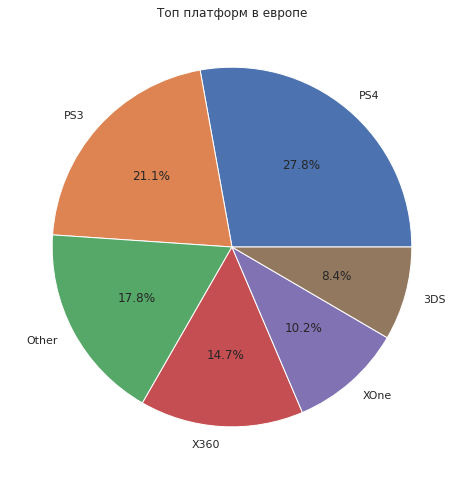

In [35]:
plt.title('Топ платформ в европе')
plt.pie(data=data_reg_eu[:6],x='eu_sales',labels='platform',autopct='%1.1f%%')
plt.show()

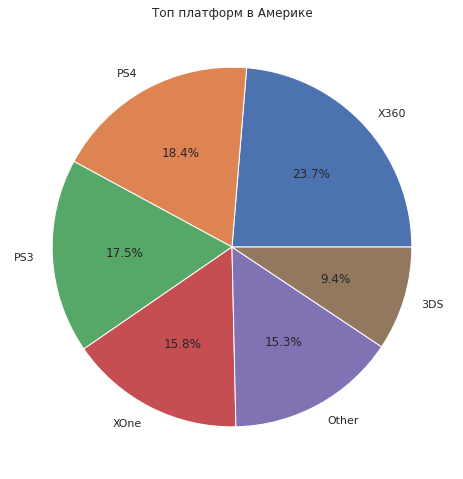

In [36]:
plt.title('Топ платформ в Америке')
plt.pie(data=data_reg_na[:6],x='na_sales',labels='platform',autopct='%1.1f%%')
plt.show()

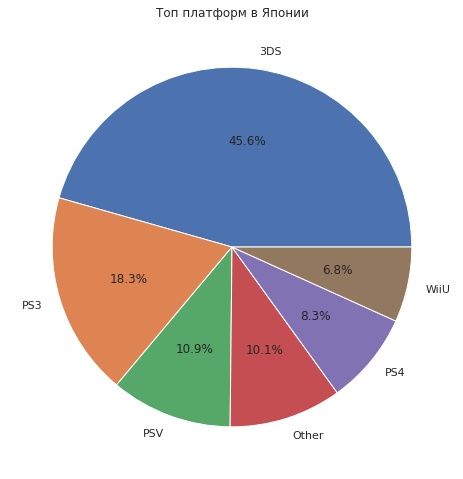

In [37]:
plt.title('Топ платформ в Японии')
plt.pie(data=data_reg_jp[:6],x='jp_sales',labels='platform',autopct='%1.1f%%')
plt.show()

Как видно из графиков: в европе самые популярные платфоры, на которые стоит ориентироваться, это ps3 и ps4.
В Америке: х360, ps3(ps4). В японии: 3ds. ps3 вторая по популярности платформа, но она сильно отстает от лидера по продажам.

Диаграммы с жанрами я сюда вставлять не буду. Они есть выше. (я бы вставил, если бы знал, как их объеденить и показать рядом друг с другом). Опишем основные выводы: в европе и америке самые популярные жанры это экшен и шутер. Жанр шутер наиболее стабилен (наименее зависит от платформы). В Японии популярны игры экшен и рол-плей.

На рейтинг ESBR, скорее всего, ориентироваться не стоит. В европе и америке около четверти всех продаж приходится на игры без этого рейтинга, в Японии - больше половины. Но в целом, игры с рейтингом M и E наиболее популярны в первых двух регионах.

Связь между отзывами пользователей и продажами отсутвует. С критиками ситуация другая (есть положительная связь, но слабая). При прочих равных на этот пункт можно обратить внимание.
